In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint, shuffle
from sklearn.metrics import accuracy_score, RocCurveDisplay

In [83]:
# Load all of our data:

In [85]:
df_states = pd.read_json("deck_states.json")
df_states.head()

,floor_0,floor_1,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_9,...,floor_47,floor_48,floor_49,floor_50,floor_51,floor_52,floor_53,floor_54,floor_55,floor_56
fdbe49b9-1846-4b0f-aea4-81f669f21767,"[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...",...,None,None,None,None,None,None,None,None,None,None
31fb9095-70e9-46cd-9069-7d6ae4c20237,"[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Defend_R, ...",None,None,...,None,None,None,None,None,None,None,None,None,None
98eb822b-53a7-481c-9e92-367e16e75499,"[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...",...,None,None,None,None,None,None,None,None,None,None
9f0d32dc-eaad-43c4-b8a7-e934c6da2614,"[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...",...,None,None,None,None,None,None,None,None,None,None
a9240145-8e3c-4033-9b58-f2ccd4cec560,"[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...","[AscendersBane, Strike_R, Strike_R, Strike_R, ...",None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [86]:
def recommend_random(cards, floor):
    n_remaining = 1000
    cur_card = 0
    prob = {card: 0 for card in cards}
    shuffle(cards)
    asc = True
    while n_remaining > 0:
        rand = randint(0, np.ceil(n_remaining*0.5))
        n_remaining -= rand
        prob[cards[cur_card]] += rand/1000
        if (asc and cur_card+1 == len(cards)) or (not asc and cur_card == 0):
            asc = not asc
        elif asc:
            cur_card += 1
        else:
            cur_card -= 1
    for card, probs in prob.items():
        prob[card] = np.round(probs, 3)
    return prob

This dataframe contains the pickrates of each card by a certain floor. Our first model (after the random baseline) will just recommend the card with the highest pickrate.

In [87]:
df_pickrates = pd.read_json("pickrates.json")
df_pickrates.head()

,AscendersBane,Strike_R,Defend_R,Bash,Anger,Hemokinesis,Feel No Pain,Disarm,Ghostly Armor,Reaper,...,WaveOfTheHand,Ragnarok,DevaForm,WindmillStrike,ForeignInfluence,Wireheading,Sanctity,LikeWater,PathToVictory,Judgement
0,0,0,0,0,0.000000,0.000000,0.0,0.000000,0.0,1.0,...,0.000000,0.0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0
1,0,0,0,0,0.800000,0.000000,0.0,0.600000,0.0,1.0,...,0.428571,0.0,0.0,0.333333,0,0.142857,0.000000,0.000000,0.062500,0
2,0,0,0,0,0.692308,0.333333,1.0,0.714286,0.0,1.0,...,0.333333,0.0,0.0,0.285714,0,0.250000,0.000000,0.166667,0.038462,0
3,0,0,0,0,0.705882,0.333333,0.5,0.454545,0.2,1.0,...,0.375000,0.0,0.0,0.222222,0,0.222222,0.111111,0.125000,0.034483,0
4,0,0,0,0,0.684211,0.500000,0.5,0.500000,0.2,1.0,...,0.315789,0.0,0.0,0.181818,0,0.200000,0.111111,0.111111,0.030303,0


In [108]:
def recommend_card_at_floor(cards, floor):
    # Given a list of cards and a floor, returns the probabilities that each card would have been picked given a card reward of only those
    floor = int(float(floor))
    prob = {}
    for card in cards:
        card = card.split("+")[0] # get rid of upgrade (for now)
        if card not in df_pickrates.columns:
            prob[card] = 0
        else:
            prob[card] = df_pickrates[card].iloc[floor]
    sum_probs = sum(prob.values())
    for key, value in prob.items():
        if sum_probs > 0:
            prob[key] = value/sum_probs
        else:
            prob[key] = 0
    return prob

In [101]:
recommend_random(["Double Tap", "Corruption", "Bludgeon"], 15)

{'Double Tap': 0.182, 'Corruption': 0.278, 'Bludgeon': 0.54}

In [109]:
recommend_card_at_floor(["Double Tap", "Corruption", "Bludgeon"], 18)

{'Double Tap': 0.14371257480890673,
 'Corruption': 0.62275449105656,
 'Bludgeon': 0.23353293413453333}

Now, we will import our data frame that contains all of our card choices on each floor, so we can evaluate each model based on ground truth.

I'm gonna be so honest, I ran out of time for this. The general plan to evaluate models is:
- For a model, set aside a certain number of runs
    - There's a ton more data available, so I can download 1,000 or so more runs and use that as a holdout set
- For each run set aside, go through each floor with a card reward given, ask the model for a prediction, and compare to what was actually picked
    - In the case SKIP was chosen, ignore it (I don't want to deal with skips yet (: )
- Compute metrics, etc etc, whatever

In [91]:
df_cards = pd.read_json("cards_seen_picked.json")
df_cards.head()

,choices,seen
fdbe49b9-1846-4b0f-aea4-81f669f21767,"{'1': 'Anger', '4': 'Hemokinesis', '6': 'Disar...","{'1': ['True Grit', 'Flame Barrier', 'Anger'],..."
31fb9095-70e9-46cd-9069-7d6ae4c20237,"{'1': 'Pommel Strike', '3': 'Flame Barrier', '...","{'1': ['Rampage', 'Heavy Blade', 'Pommel Strik..."
98eb822b-53a7-481c-9e92-367e16e75499,"{'1.0': 'Power Through', '5': 'Thunderclap', '...","{'1.0': ['Wild Strike', 'Clothesline', 'Power ..."
9f0d32dc-eaad-43c4-b8a7-e934c6da2614,"{'1': 'Dropkick', '6': 'Battle Trance', '10': ...","{'1': ['Reckless Charge', 'Perfected Strike', ..."
a9240145-8e3c-4033-9b58-f2ccd4cec560,"{'1': 'Twin Strike', '2': 'Second Wind', '3': ...","{'1': ['Iron Wave', 'Warcry', 'Twin Strike'], ..."


For now (because our only model is already trained on everything), we're just going to evaluate on the training set. I'll go back and split the data later.

In [103]:
def get_best_rec(rec_dict):
    best_prob = 0
    best_card = ""
    for card, prob in rec_dict.items():
        if prob > best_prob:
            best_prob = prob
            best_card = card
    
    return best_card, best_prob

In [125]:
def evaluate(model):
    preds = []
    probs = []
    actual = []
    
    rand_preds = []
    rand_probs = []
    rand_actual = []
    for index, row in df_cards.iterrows():
        choices = row["choices"]
        seen = row["seen"]
        
        for floor in seen:
            offered = seen[floor]
            picked = choices[floor]
            
            rec_card, rec_prob = get_best_rec(model(offered, floor))
            rand_card, rand_prob = get_best_rec(recommend_random(offered, floor))
            
            preds.append(1)
            rand_preds.append(1)
            
            probs.append(rec_prob)
            rand_probs.append(rand_prob)
            
            if rec_card.split("+")[0] == picked:
                actual.append(1)
            else:
                actual.append(0)
            if rand_card.split("+")[0] == picked:
                rand_actual.append(1)
            else:
                rand_actual.append(0)
    
    acc = accuracy_score(actual, preds)
    rand_acc = accuracy_score(rand_actual, rand_preds)
    
    fig = plt.figure()
    ax = fig.add_subplot()
    RocCurveDisplay.from_predictions(rand_actual, rand_probs, ax=ax,
                                     name="Random ROC Curve")
    RocCurveDisplay.from_predictions(actual, probs, ax=ax,
                                     name=f"{model.__name__} ROC Curve")
    plt.show()
    
    print(f"Model Accuracy: {acc:.2f}\nRandom Accuracy: {rand_acc:.2f}")

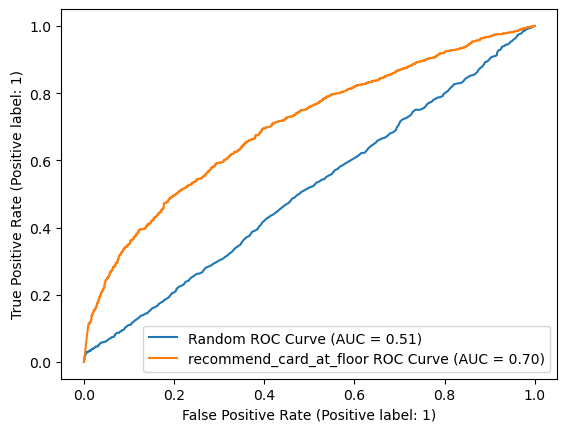

Model Accuracy: 0.68
Random Accuracy: 0.31


In [126]:
evaluate(recommend_card_at_floor)